In [1]:
%matplotlib inline  

import sys, os, time, math
import cPickle as pickle
import tensorflow as tf
sys.path.append('/Users/matt.meng/dev/seq2seq_model')
from data import DataGenerator, process_batch
from utils import model_meta_file
from data_preprocess import TOKEN_DICT, _GO, _EOS
import matplotlib.pyplot as plt

In [2]:
pickle_file = 'processed_title_data.pkl'
local_model_path = '/Users/matt.meng/local_tensorflow_content/seq2seq'
encoder_output_c_name = 'encoder_decoder_sequence/encoder/while/Exit_2:0'
encoder_output_h_name = 'encoder_decoder_sequence/encoder/while/Exit_3:0'


pickle_file_path = os.path.join(os.path.expanduser("~"), pickle_file)
with open(pickle_file_path, 'rb') as input_stream:
    data = pickle.load(input_stream)
titles = data['titles']
reverse_token_dict = data['reverse_token_dict']
title_urls = data['url']
title_pageViews = data['pageViw']

In [3]:
data.keys()

['url', 'reverse_token_dict', 'pageViw', 'titles', 'token_dict']

In [24]:
#c_vector_list, h_vector_list = [], []
vector_dict = {}
saver = tf.train.import_meta_graph(model_meta_file(local_model_path))
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(local_model_path))
    
    encoder_inputs = sess.graph.get_tensor_by_name("initial_inputs/encoder_inputs:0")
    decoder_inputs = sess.graph.get_tensor_by_name("initial_inputs/decoder_inputs:0")
    decoder_targets = sess.graph.get_tensor_by_name("initial_inputs/decoder_targets:0")
    dropout_input_keep_prob = sess.graph.get_tensor_by_name("initial_inputs/dropout_input_keep_prob:0")

    encoder_output_c = sess.graph.get_tensor_by_name('encoder_decoder_sequence/encoder/while/Exit_2:0')
    encoder_output_h = sess.graph.get_tensor_by_name('encoder_decoder_sequence/encoder/while/Exit_3:0')
    counter = 0
    start_time = time.time()
    for i in xrange(len(titles)):
        counter += 1
        vector_dict[title_urls[i]] = {'pageView' : title_pageViews[i], 
                                      'title_string' : ' '.join(map(reverse_token_dict.get, titles[i]))}
        #title = ' '.join(map(reverse_token_dict.get, titles[i]))
        encoder_inputs_, _ = process_batch([titles[i] + [TOKEN_DICT[_EOS]]])
        decoder_targets_, _ = process_batch([titles[i] + [TOKEN_DICT[_EOS]]])
        decoder_inputs_, _ = process_batch([[TOKEN_DICT[_GO]] + titles[i]])
        c_vector, h_vector = sess.run([encoder_output_c, encoder_output_h], {encoder_inputs : encoder_inputs_,
                                                                             decoder_inputs : decoder_inputs_, 
                                                                             decoder_targets : decoder_targets_, 
                                                                             dropout_input_keep_prob : 1.})
        vector_dict[title_urls[i]]['vectors'] = (c_vector[0] + h_vector[0])
        #c_vector_list.append(c_vector)
        #h_vector_list.append(h_vector)
        if counter % 5000 == 0:
            print 'finish processing {} articles using {:.2f} seconds...'.format(counter, time.time() - start_time)

warning, more than one model meta file is found in /Users/matt.meng/local_tensorflow_content/seq2seq
INFO:tensorflow:Restoring parameters from /Users/matt.meng/local_tensorflow_content/seq2seq/models-2100000
finish processing 5000 articles using 13.14 seconds...
finish processing 10000 articles using 28.06 seconds...
finish processing 15000 articles using 45.64 seconds...


In [25]:
print len(title_pageViews), len(vector_dict)

17185 17185


In [26]:
key = vector_dict.keys()[10]
print vector_dict[key].keys()

['pageView', 'vectors', 'title_string']


In [27]:
vector_items = vector_dict.items()

In [28]:
sorted_vecor = sorted(vector_items, key=lambda x: x[1]['pageView'], reverse=True)

In [29]:
sorted_vecor[0]

('http://www.nydailynews.com/new-york/delta-pilot-flight-attendant-fight-delays-takeoff-laguardia-article-1.3352751',
 {'pageView': 234898,
  'title_string': 'delta pilot flight attendant fight delays _UNK at _UNK',
  'vectors': array([-2.00210595,  0.70956612,  1.2261126 ,  4.91165352, -5.52067995,
          0.65053552,  3.38198543, -1.98489177, -1.53014588, -2.77692223,
          0.41954407,  1.38518429, -4.1707468 ,  3.31093717, -6.82586336,
         -2.563169  , -1.93261743,  0.08439458, -0.34545758, -5.91424608,
         -2.6972177 ,  1.6733501 , -1.5586071 ,  2.33327675,  3.88655853,
         -1.36372066,  1.96337891,  1.23290229,  1.82884359,  1.90434992,
          0.9236629 , -9.39466476], dtype=float32)})

In [30]:
vector_dict['http://www.chicagotribune.com/lifestyles/sns-201706141112--tms--hscopebctnzz-a20170708-20170708-story.html']

{'pageView': 1,
 'title_string': 'linda c black horoscopes for # # ##',
 'vectors': array([-1.37608314, -1.06412494, -3.16853094,  5.78051901, -3.40847945,
        -0.58878434,  1.30917573, -3.26261854, -1.60178423, -0.81033075,
         2.88599205,  1.29148567, -3.21983457,  1.89780283, -4.40292168,
        -2.30535603, -2.32270789,  0.59876782, -6.09389591, -3.09071398,
        -4.89437056,  2.10428381,  1.08439183,  3.3922255 , -0.34335831,
        -2.47728777, -0.95580059,  2.11615801, -0.52365917,  0.45603269,
         4.67831898, -7.77249098], dtype=float32)}

In [31]:
def square_rooted(x):
    return math.sqrt(sum([a*a for a in x]))
 
def euclidean_distance(x,y):
     return math.sqrt(sum(math.pow(a - b, 2) for a, b in zip(x, y)))

def manhattan_distance(x,y): 
    return sum(abs(a - b) for a,b in zip(x,y))

def cosine_similarity(x, y):
    numerator = sum(a*b for a, b in zip(x,y))
    denominator = square_rooted(x) * square_rooted(y)
    #denominator = (square_rooted(x) + square_rooted(y))

    return numerator / denominator

In [59]:
index = 7
print sorted_vecor[index][1]['title_string']
selected_key = sorted_vecor[index][0]
print selected_key

nba free agency : after derrick rose deal ## players who are still available
https://www.cbssports.com/nba/news/nba-free-agency-after-derrick-rose-deal-25-players-who-are-still-available/


In [66]:
results = []
selected_key = 'http://www.cbssports.com/nba/news/nba-draft-lavar-ball-guarantees-lonzo-will-lead-lakers-to-playoffs-next-season/'
print selected_key
print '\n \n'
for key in vector_dict.keys():
    if key == selected_key:
        continue
    #vector_index = 0
    #cosine_result = cosine_similarity(vector_dict[selected_key]['vectors'][vector_index], vector_dict[key]['vectors'][vector_index])
    #euclidean_result = euclidean_distance(vector_dict[selected_key]['vectors'][vector_index], vector_dict[key]['vectors'][vector_index])
    #result = cosine_result
    
    cosine_result = cosine_similarity(vector_dict[selected_key]['vectors'], vector_dict[key]['vectors'])
    euclidean_result = euclidean_distance(vector_dict[selected_key]['vectors'], vector_dict[key]['vectors'])
    #result = cosine_result
    result = euclidean_result
    #result = 10 * (1 - cosine_result) * euclidean_result
    #result = manhattan_distance(vector_dict[selected_key]['vectors'][0], vector_dict[key]['vectors'][0])
    if result < 7.5:
    #if result > 0.96:
        print key, result
        #print vector_dict[key]['pageView']
    
    #print cosine_result, euclidean_result, result
    results.append(result)

http://www.cbssports.com/nba/news/nba-draft-lavar-ball-guarantees-lonzo-will-lead-lakers-to-playoffs-next-season/

 

http://www.chicagotribune.com/sports/baseball/whitesox/ct-mark-buehrle-number-retired-white-sox-20170621-story.html 7.15864151953
http://www.cbssports.com/nba/news/nba-free-agency-2017-breaking-down-the-biggest-needs-free-agent-fits-for-each-team/ 6.17284305998
https://www.cbssports.com/fantasy/football/news/broncos-devontae-booker-out-6-to-8-weeks-with-wrist-injury/ 7.45207165218
https://www.cbssports.com/fantasy/football/news/broncos-devontae-booker-will-get-opportunities-with-the-first-team/ 7.3106981743
https://www.cbssports.com/fantasy/football/news/bears-mitchell-trubisky-will-not-open-season-as-starting-quarterback/ 7.20473918611
https://www.cbssports.com/tennis/news/wimbledon-2017-roger-federer-rolls-to-a-record-eighth-title-19th-grand-slam-win/ 6.03781379096
http://www.chicagotribune.com/sports/baseball/whitesox/ct-mark-buehrle-number-retired-white-sox-20170621

(array([   2.,    1.,    0.,    6.,    9.,   13.,   17.,   25.,   43.,
          51.,   98.,  110.,  127.,  190.,  247.,  287.,  373.,  446.,
         544.,  579.,  729.,  731.,  836.,  907.,  930.,  913.,  919.,
         930.,  885.,  842.,  783.,  744.,  658.,  595.,  545.,  438.,
         367.,  289.,  250.,  192.,  152.,  105.,  108.,   60.,   46.,
          26.,   18.,    8.,    7.,    3.]),
 array([  6.03781379,   6.38678424,   6.73575469,   7.08472513,
          7.43369558,   7.78266603,   8.13163648,   8.48060692,
          8.82957737,   9.17854782,   9.52751826,   9.87648871,
         10.22545916,  10.57442961,  10.92340005,  11.2723705 ,
         11.62134095,  11.9703114 ,  12.31928184,  12.66825229,
         13.01722274,  13.36619319,  13.71516363,  14.06413408,
         14.41310453,  14.76207498,  15.11104542,  15.46001587,
         15.80898632,  16.15795676,  16.50692721,  16.85589766,
         17.20486811,  17.55383855,  17.902809  ,  18.25177945,
         18.6007499 ,  1

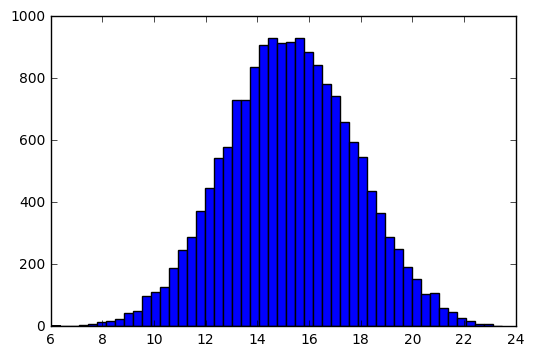

In [64]:
plt.hist(results, bins=50)